In [4]:
def TnFactory(n,x):
    if n==0:
        return 1
    if n==1:
        return x
    else:
        return 2 * x* TnFactory(n-1,x)-TnFactory(n-2,x)
        

In [5]:
import numpy as np
import matplotlib.pyplot as plt

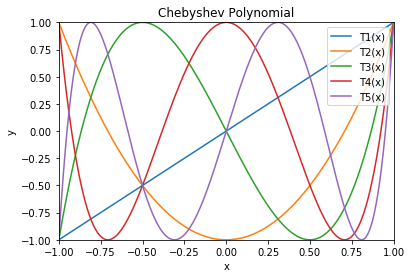

In [6]:
for j in range(1,6):
    plt.plot(np.linspace(-1.0,1.0,1000),[TnFactory(j,i) for i in np.linspace(-1.0,1.0,1000)],label='T'+str(j)+'(x)')
    plt.legend(loc='upper right')
plt.axis([-1, 1, -1, 1])
plt.xlabel('x')
plt.ylabel('y')
plt.title('Chebyshev Polynomial')
plt.show()

# Week 11: Networks 3 (epidemiology)


While researchers have been modeling the spread of diseases and information for many years, the COVID-19 pandemic playing out right now puts a new emphasis on the importance of being able to model (and thus predict) how diseases propagate through populations. So how do you most effectively model the spread of a disease? There are many^ ways, and all of them (at least the useful ones) involves networks. In this notebook you will get your hands on a couple different modeling approaches. Specifically:

* Spreading processes on static networks
* Spreading processes on temporal networks
* Metapopulation models

**Questions**: Outside of class, use [issue on GitHub](https://github.com/abjer/tsds/issues) for asking questions.

## Imports

In [1]:
%matplotlib inline
import matplotlib.pylab as plt
import networkx as nx
import netwulf as nw

## Exercises

In a *contact network* nodes are people and links represent interactions that can happen between people. You can use such a network as a *substrate* for simulating the spreading of "something". Spreading of what? That's up to you. It can be a disease, a behavior, a piece of information, anything you can imagine people may pass along. There's a whole subfield of Network Science which deals with this, but the fundamental idea is actually quite simple:

> Nodes that are connected can transmit this "something" with a probability. Each timestep of the simulation is an opportunity for the "something" to spread.

You can then make this more nuanced by adding extra criteria for transmission. For disease modeling these can e.g. be that nodes can only be infected after multiple exposures or if multiple neighbors are infected, that they can be cured and become resistant/susceptible with some probability, that they may die and exit the simulation creating a void in the network, that becoming infected makes them change their links, that godzilla walks in and eats everyone—the possibilities are endless and you decide which rules exist in the simulation universe.

Generally speaking, there are four major classes of so-called "compartmental models" in network epidemiology:
* *Susceptible-Infected (SI)*: Nodes are susceptible at start, and once they are infected they never recover. This models spreading of unforgetable information, or diseases that people get and pass on, and never recover from (like HIV, herpes, etc.).
* *Susceptible-Infected-Susceptible (SIS)*: Nodes are susceptible, then get infected and stay infected for some time, then get susceptible again, an the cycle continues. This could model things like the flu which comes and goes and you get and recover from over and over again.
* *Susceptible-Infected-Resistant (SIR)*: Nodes become infected and after some time they gain resistance so that they can niether become infected nor spread disease/information further. Once they are resistant they are essentially "removed" from the network, so this type of model works for diseases where people recover and gain resistance as well as ones that kill people, as niether type of person can transmit (measles, chickenpox but also rabies, Creutzfeldt–Jakob disease, etc.).
* *Susceptible-Infected-Resistant-Susceptible (SIRS)*: Probably self-explanatory if you understood the above.

The idea that drives the "compartmenal" modeling approach is that within a population you can assign each
individual to a compartment based on their "state" (infected, susceptible, etc.). When you start the simulation,
individuals then flow between compartments with specific flow rates.

![img](https://upload.wikimedia.org/wikipedia/commons/9/93/SIR_Flow_Diagram.svg)

This then allows us to describe the flow of individuals between compartments (and thus the spreading of the disease)
using differential equations. For example in the simple SIR model shown above, the dynamics can be described with
three differential equations (one for each compartment). They each tell us how fast the population in the corresponding
compartment it changing:

$$\frac{dS}{dt} = -\beta SI$$

$$\frac{dI}{dt} = \beta SI - \gamma I$$

$$\frac{dR}{dt} = \gamma I$$

So at a given point in time how many people are leaving the susceptible compartment and entering the Infected compartment?
Well that's simply the the number of susceptible $S$ times the number of infected $I$ multipled with some disease-specific constant $\beta$.

And what's the growth in the number of infected? Easy! It's just the number of people coming in from the susceptible compartment $\beta SI$ minus all the people leaving for the "Recovered" compartment $\gamma I$, where gamma is some constant that describs how fast people recover.

And the rate at which people enter the recovered state? If you understood the above you can explain this to yourself.

**That's it!**. That's how all compartmental models work!

> **Ex. 11.1.1**: But as I wrote above there are many different types of compartmental models. Write down the rate equations for the SIS model:
>
>![img](https://upload.wikimedia.org/wikipedia/commons/c/cb/SIS_compartment_model.svg)
>
> Follow the reasoning in the example for the SIR model above. Answer the following:
* how many equations you need if there are two compartments.
* What specifically does each equation describe?
* What do $\beta$ and $\gamma$ intuitively describe? What can you say about a disease with a really big $\gamma$? Or a really small $\gamma$? How about big or small $\beta$?

Two functions.
$$\frac{dS}{dt} = -\beta SI + \gamma I$$

$$\frac{dI}{dt} = \beta SI - \gamma I$$

The first one descibes at a given point in time how many people are leaving the susceptible compartment and entering the Infected compartment, the second one descibes the growth of infection. 
$\beta$ is the the likelihood that the disease will be transmitted, and $\gamma$ is the recovered rate. If $\gamma$ is big / $\beta$ is small, then number of the infection will decrease significantly and the disease will disappear eventually. In this model, the fraction of infected people is fixed, some people get cured while others are infected. If $\beta$ is really big / $\gamma$ is small then the fraction of infection is big.


> **Ex. 11.1.2** (optional): If you really understood the above, you should have no trouble writing down the equations for a SIRS
model. Go ahead and try. Hint: You will need to introduce a new constant that describes the rate at which people move from R to S.

$$\frac{dS}{dt} = -\beta SI +\alpha R $$

$$\frac{dI}{dt} = \beta SI - \gamma I$$

$$\frac{dR}{dt} = \gamma I -\alpha R $$

where $\alpha$ is the likelihood of recovered becomes susceptible again.


> **Ex. 11.1.3**: Professor of physics and mathematic and all around cool guy, Dirk Brockmann,
makes interactive articles called *Explorables* that introduce ideas in Complexity science. Read/play with
[his explorable](http://www.complexity-explorables.org/explorables/neighbors/) on targeted vaccination to mitigate epidemic spreading in the real world and answer the
following questions:
> 1. In the BA network, roughly what percentage of the population do you have to vaccinate with **strategy A** to only get around 10
infected individuals? What about **startegy B** and **strategy C**?
> 2. **strategy A** and **strategy C** are both entirely random, but one is much more effective than the other. Explain
why. What clever idea is **strategy C** employing?
> 3. Why is this effect larger in the BA network than in the ER network?

Roughly 80%, 15%, 50% people have to be vaccinated with strategy A, B, C.
Bacause on average a node's neighbors' degree is larger than the node's own degree, which is called friend paradox. Thus, in strategy C, the probability of picking a node is proportional to the node's degree, so that it is not entirely random but more likely to pick a node with higher degree. 
Because the BA model has a fat tailed degree distribution. While in ER network, all nodes have comparable degree, k is around <k\>.

> **Ex. 11.1.4**: Choose one of these two explorables ([1](http://www.complexity-explorables.org/explorables/herd/) or [2](http://www.complexity-explorables.org/explorables/epidemonic/)) read/play with and understand it, and explain in your own words what phenomenon it communicates.

Herd community: When many people get vaccinated, they are immune from this disease. If the proportion of the immune is p, then the susceptible is (1-p). Many susceptible nodes are then isolated from the infectious ones. Although they are not vaccinated, they will not be infected. If R0(1-p) <1, the number of infection will decrease and the disease will die out eventually, where the R0 is the basic reproductive number.

> **Ex. 11.1.5**: The simplest compartmental model is the *SI* model. Below I have implemented a simulation of such a model.
You can see in line 5 that I initialize all nodes in the *S* compartment, but after running, all nodes are in the *I* compartment.
Does this make sense to you?
1. Comment the code abundantly, explaining what's happing at each step.
2. Adapt the code and make a plot of the fraction of infected over time. You may have to restart it a couple of time to make sure patient 0 is someone connected to the rest of the population.
3. Extend the code such after a variable number of timesteps `T_I` infected nodes become susceptible again. Set `T_I = 10` to begin with and plot the fraction of infected over time for 200 timesteps. Does the result make sense? Comment on what you see.

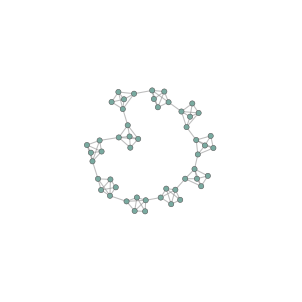

In [8]:
G = nx.connected_caveman_graph(10, 5)
_ = nw.visualize(G) # Uncomment if you want to have a look at the network

In [8]:
import numpy as np

p_I = 0.1 
n_iter = 200

I = set()
S = set(G.nodes())
N=len(S)
patient0 = np.random.choice(list(S)) # initialize all nodes in the S compartment

I.add(patient0) # add a node to I compartment, patient 0
S.remove(patient0) # remove that node from S compartment
num_I=[]
num_S=[]
for t in range(n_iter):
    for infected_node in list(I): 
        neighbors = G.neighbors(infected_node) # find neighbours of the infected node
        infected_neighbors = set([n for n in neighbors if np.random.random() < p_I]) # randomly infect the neighbor
        I |= infected_neighbors # add the infected neighbors to the I compartment 
        S -= infected_neighbors # remove the infected from S compartment
    num_I.append(len(I)/N)
    num_S.append(len(S)/N)
    
    

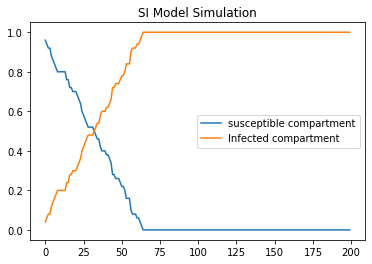

In [9]:
plt.plot(num_S,label= 'susceptible compartment')
plt.plot(num_I,label='Infected compartment')
plt.title('SI Model Simulation')
plt.legend()
plt.show()

In [10]:
p_I = 0.1 
n_iter = 200
T_I = 10
I = set()
S = set(G.nodes())
N= len(S)
patient0 = np.random.choice(list(S)) # initialize all nodes in the S compartment
I.add(patient0) # add a node to I compartment, patient 0
S.remove(patient0) # remove that node from S compartment
days_list=[]
num_I=[]
num_S=[]
n=0
for t in range(n_iter):
    for infected_node in list(I):
        days=set()
        neighbors = G.neighbors(infected_node) # find neighbours of the infected node
        infected_neighbors = set([n for n in neighbors if np.random.random() < p_I]) # randomly infect the neighbor
        I |=infected_neighbors # add the infected neighbors to the I compartment 
        S -= infected_neighbors # remove the infected from S compartment
        if not infected_neighbors and I >= infected_neighbors:
            pass
        else:
            days |=infected_neighbors #add the infected neighbors that are not in the I compartment to days
    if days:
        days_list.append(days) # build a new list
    if len(I)>=T_I: #from day 10
        try:
            I -= days_list[0] #remove the recovered from I compartment 
            S |= days_list[0] #add the recovered to S compartment
            del days_list[0]
        except:
            pass
    num_I.append(len(I)/N)
    num_S.append(len(S)/N)
    

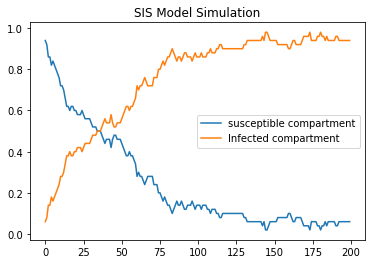

In [11]:
plt.plot(num_S,label= 'susceptible compartment')
plt.plot(num_I,label='Infected compartment')
plt.title('SIS Model Simulation')
plt.legend()
plt.show()

> **Ex. 11.1.6**: Use what you have learned and implement an SIRS model.
* Run it on the Facebook network from last week (so load that into a `networkx.Graph`).
* Record the fraction of infected, susceptiple and recovered over time.
* After the simulation has run, plot these quantities over time and comment on your results
* Be proud of yourself for having solved a really interesting problem.

In [12]:
import pandas as pd
data = pd.read_csv(
    "facebook-wall.txt.gz",
    delimiter="\t",
    header=None,
    names=['user1', 'user2', 'timestamp']
)

data.head(10)
t0 = data.timestamp.max() - 86400 * 7  # Lower bound of time-slice (here: 7 days before last wall post)
t1 = data.timestamp.max()              # Upper bound of time-slice

# Subset of the pandas dataframe
data_t = data.loc[data.timestamp.between(t0, t1)]

# Count the number of times each link occurs and store that in a new 'weight' column
data_t = data_t.groupby(['user1', 'user2']).size().reset_index(name='weight')

# Create a `nx.DiGraph` from this dataframe
G_t = nx.from_pandas_edgelist(data_t, 'user1', 'user2', 'weight', create_using=nx.DiGraph)
def network(t0,t1):
    # Subset of the pandas dataframe
    data_t = data.loc[data.timestamp.between(t0, t1)]

    # Count the number of times each link occurs and store that in a new 'weight' column
    data_t = data_t.groupby(['user1', 'user2']).size().reset_index(name='weight')

    # Create a `nx.DiGraph` from this dataframe
    G_t = nx.from_pandas_edgelist(data_t, 'user1', 'user2', 'weight', create_using=nx.DiGraph)
    return G_t
G=network(t0,t1)
G1=G.to_undirected()

In [13]:
def connected_component_subgraphs(G):
    for c in nx.connected_components(G):
        yield G.subgraph(c)
GCC = max(connected_component_subgraphs(G1),key=len)

In [194]:
p_I = 0.1 
n_iter = 500
T_I = 10
I = set()
S = set(GCC.nodes())
R=set()
N= len(S)
patient0 = np.random.choice(list(S)) # initialize all nodes in the S compartment
I.add(patient0) # add a node to I compartment, patient 0
S.remove(patient0) # remove that node from S compartment
num_I=[]
num_S=[]
num_R=[]
n=0
for t in range(n_iter):
    for infected_node in list(I):
        neighbors = GCC.neighbors(infected_node) # find neighbours of the infected node
        infected_neighbors = set([n for n in neighbors if np.random.random() < p_I]) # randomly infect the neighbor
        I |=infected_neighbors # add the infected neighbors to the I compartment 
        S -= infected_neighbors # remove the infected from S compartment
    if len(I)>=T_I: #from day 10
        recovery = set([n for n in I if np.random.random() < 1/T_I]) #randomly recovered
        I -= recovery
        R |= recovery
    num_I.append(len(I)/N)
    num_S.append(len(S)/N)
    num_R.append(len(R)/N)
    
    
    

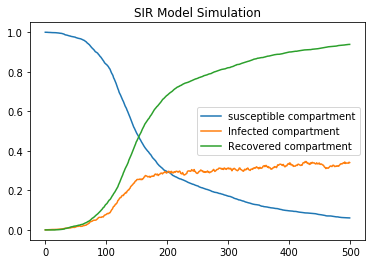

In [195]:
plt.plot(num_S,label= 'susceptible compartment')
plt.plot(num_I,label='Infected compartment')
plt.plot(num_R, label='Recovered compartment')
plt.title('SIR Model Simulation')
plt.legend()
plt.show()
# I think this is not correct,the sum is not even 1
# I expect that people are either infected or recovered and the number of susceptible will be zero
# but if I set only people who are not recovered will get infected it is still not correct 

### Further learning

Since the above exercises teaches you how to write down epidemic models (as systems of differential equations)
and subsequently teaches you how to simulate a spreading process on a network to obtain data on infected/susceptible/recovered
over time, you would think it natural that I also taught you how to fit these epidemic models to such data.
This, however, is going a bit too far as this is not a course in computational epidemiology. But if you want to
figure out how to do it, you literally just need to Google search for "fit SIR model".

And finally, a note on how these models are used in the real world. The state-of-the-art in epidemiological modeling is something called "meta popultion models". They are essentially systems of compartmental models. One component in such a model may be a country, and it has its own little SI, SIR or SIRS model. Components are then coupled because there are people moving between them. The paper *The Hidden Geometry of Complex,
Network-Driven Contagion Phenomena* by Dirk Brockmann and Dirk Helbing published in Science in 2013 ([link here](https://www.dropbox.com/s/hxprfyr51fwh907/brockmann13.pdf?dl=0)) sets up such a model for the world using airline traffic as a proxy for people flow between countries. It is a must read if you
are curious about how the pros predict things like when a disease will arrive in a certain place or where a disease originated. I strongly recommend reading it and understanding the figures, it is a stroke of genius.